# Project Description

Model Fitness provided us with CSV files containing data on churn for a given month and information on the month preceding it. The dataset includes the following fields:
- 'Churn' — the fact of churn for the month in question
<br>Current dataset fields:<br>
<br>User data for the preceding month<br>
- 'gender'
- 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
- 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- 'Phone' — whether the user provided their phone number
- 'Age'
- 'Lifetime' — the time (in months) since the customer first came to the gym<br>
<br>Data from the log of visits and purchases and data on current membership status<br>
- 'Contract_period' — 1 month, 3 months, 6 months, or 1 year
- 'Month_to_end_contract' — the months remaining until the contract expires
- 'Group_visits' — whether the user takes part in group sessions
- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
- 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.
File path: /datasets/gym_churn_us.csv. 

In order to fight churn, Model Fitness has digitized a number of its customer profiles. Our task is to analyze them and come up with a customer retention strategy.<br><br>
We will:

- Predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn most
- Draw basic conclusions and develop recommendations on how to improve customer service:
- Identify target groups
- Suggest measures to cut churn
- Describe any other patterns we see with respect to interaction with customers

# Step 1. Download the data

In [1]:
 pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import sys
sys.setrecursionlimit(10**6)
import scipy.stats as stats
from functools import reduce
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [3]:
data= pd.read_csv('/datasets/gym_churn_us.csv')
pd.set_option('max_colwidth', 300)
#Studying the general information 
display(data.head())
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


<h4>Conclusion

Successfully downloaded the data and read the file. There are 4000 entries and 14 columns.

# Step 2. Carry out exploratory data analysis (EDA)

<h3>Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method).

In [4]:
#Studying the general information 
print('\n\nGym Data:')
display(data.describe().T)
print('\n Number of duplicated rows in data dataframe:',data.duplicated().sum())
print()
print('\nSkewness')
print(data.skew())
print('\n\nNull Values:')
print(data.isnull().sum()*100/len(data))



Gym Data:


,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000



 Number of duplicated rows in data dataframe: 0


Skewness
gender                              -0.041024
Near_Location                       -1.909935
Partner                              0.053039
Promo_friends                        0.829541
Phone                               -2.734064
Contract_period                      0.712355
Group_visits                         0.356667
Age                                 -0.060303
Avg_additional_charges_total         0.616884
Month_to_end_contract                0.807789
Lifetime                             1.927463
Avg_class_frequency_total            0.252975
Avg_class_frequency_current_month    0.262098
Churn                                1.063900
dtype: float64


Null Values:
gender                               0.0
Near_Location                        0.0
Partner                              0.0
Promo_friends                        0.0
Phone                                0.0
Contract_period                      0.0
Group_visits        

In [5]:
#changing the column names to be consistent 
data.columns = data.columns.str.lower()

#Downcasting the integer datatype to unsigned 
cols = data.columns.drop({'avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month'})
data[cols] = data[cols].apply(pd.to_numeric, downcast='unsigned')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null uint8
near_location                        4000 non-null uint8
partner                              4000 non-null uint8
promo_friends                        4000 non-null uint8
phone                                4000 non-null uint8
contract_period                      4000 non-null uint8
group_visits                         4000 non-null uint8
age                                  4000 non-null uint8
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null uint8
lifetime                             4000 non-null uint8
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null uint8
dtypes: float64(3), uint8(11)
memory usage: 136.8 KB


<h4>Conclusion

- Changed the column names to smaller case for better consistency and ease
- As we saw while reading the data that `month_to_end_contract` was a float even though the values were int, so we downcasted it into integer along with all other integer datatypes as they were also less than 50.
- Finally we also checked for null and duplicate values in the dataframe and found that there were none

<h3>Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).

In [6]:
data_churn = data.groupby(['churn']).mean().reset_index()
data_churn

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<h4>Conclusion

From the above mean feature values we can say that:
- gender plays equal role in the churn rate 
- customers who stay near are the ones who did not leave
- customers who were tied up with a Partner company were the ones who stayed
- high contract period, high group visits, older age, higher month_to_end_contract are the customers who stayed
- naturally these customers have higher lifetime, avg_additional_charges_total and avg_class_frequency_current_month

<h3>Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

Plots for customers who have left.

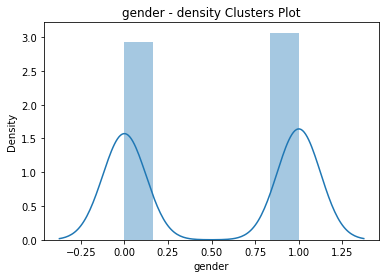

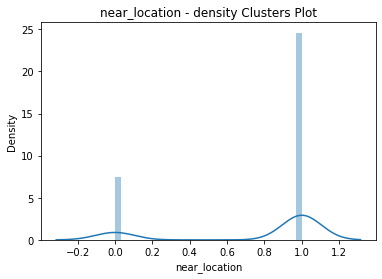

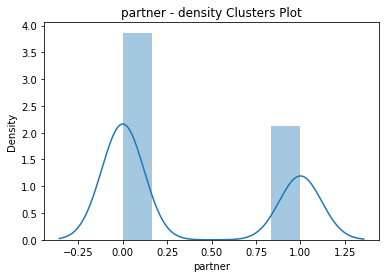

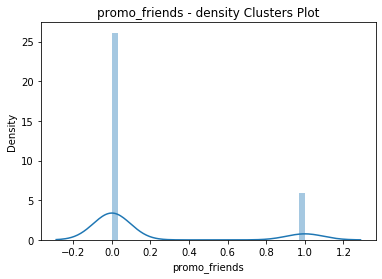

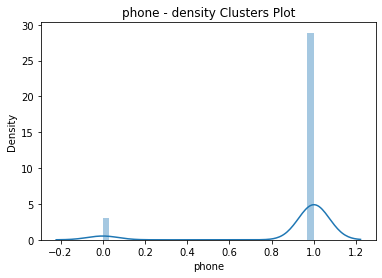

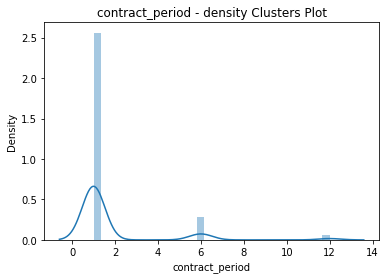

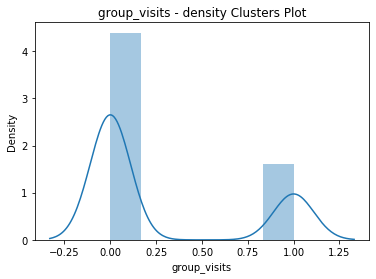

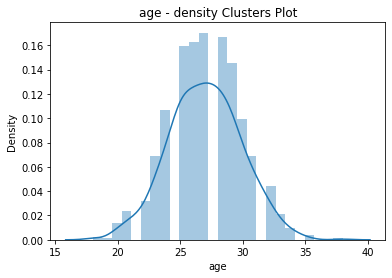

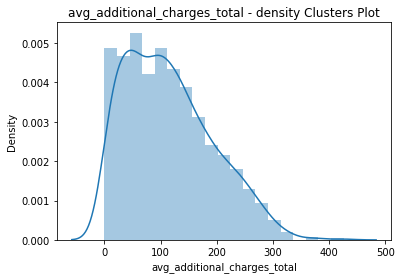

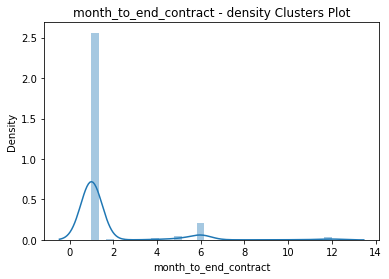

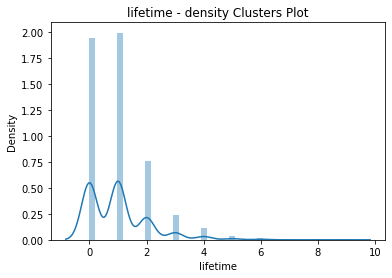

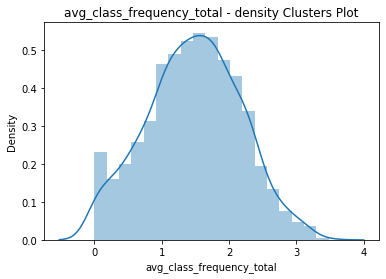

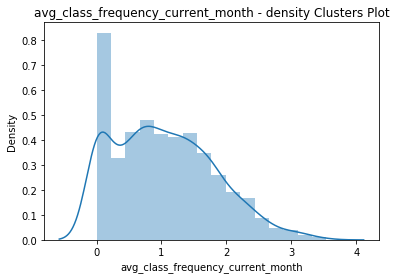

In [7]:
#Plots for customers who have left.
churned_data = data[data['churn']==1].drop('churn', axis = 1)

for feature in churned_data.columns:
    if churned_data[feature].dtype == np.int64:
        sns.histplot(x=feature, data=churned_data)
        plt.title('{} - count Clusters Plot'.format(feature))
        plt.show()
    else:
        sns.distplot(churned_data[feature])
        plt.title('{} - density Clusters Plot'.format(feature))
        plt.show() 

<h4>Conclusion

For the customers who have left we can see that 
- the gender is almost equally divided
- strangely those staying nearby are the ones who have left compared to staying far away
- similarily Partner companies users are more as compared to normal users
- less contract period users are more in number
- single visit users are more in number
- 25-28 age people are more in number
- smaller month_to_end_contract are more
- less lifetime
- avg_class_frequency = 1.5

Plots for customers who have stayed.

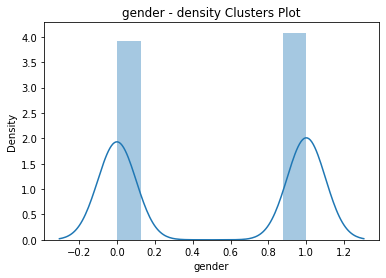

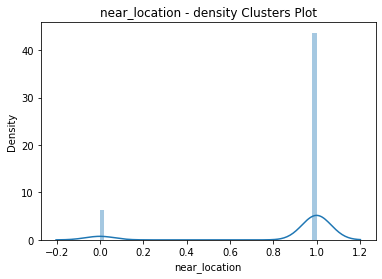

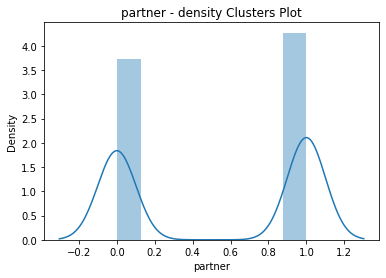

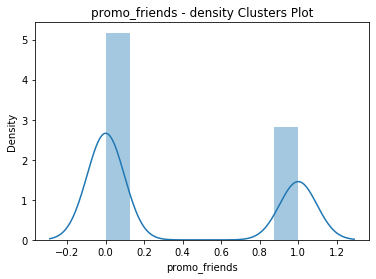

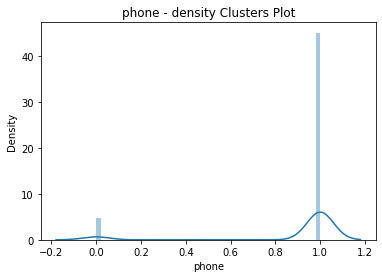

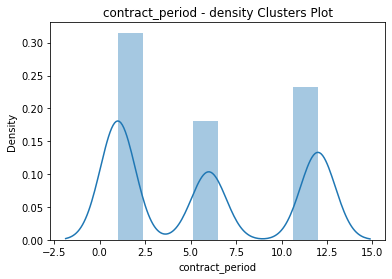

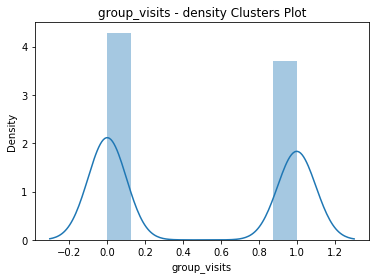

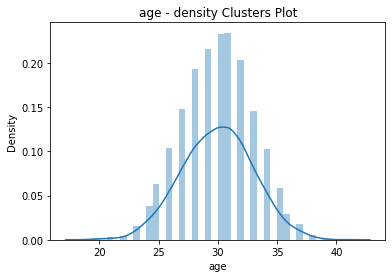

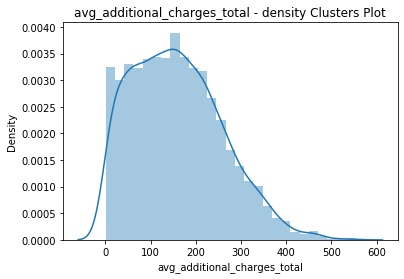

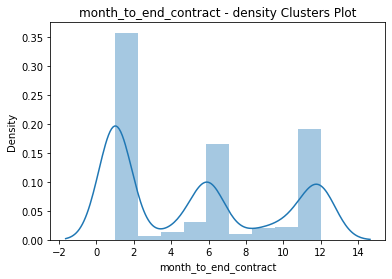

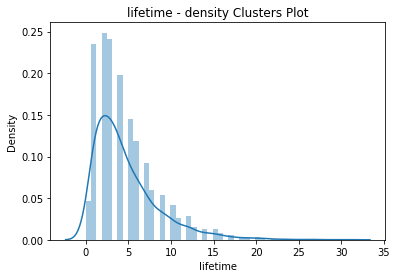

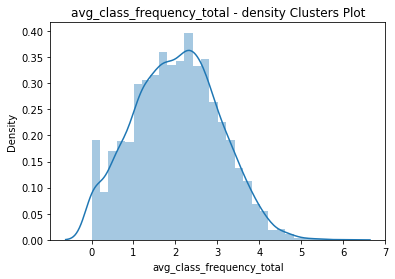

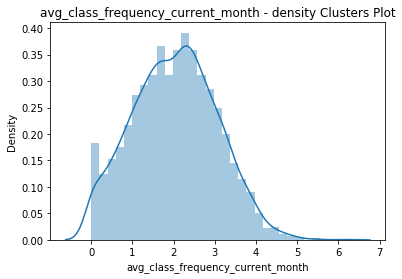

In [8]:
#Plots for customers who have stayed.
unchurned_data = data[data['churn']==0].drop('churn', axis = 1)

for feature in unchurned_data.columns:
    if unchurned_data[feature].dtype == np.int64:
        sns.histplot(x=feature, data=unchurned_data)
        plt.title('{} - count Clusters Plot'.format(feature))
        plt.show()
    else:
        sns.distplot(unchurned_data[feature])
        plt.title('{} - density Clusters Plot'.format(feature))
        plt.show() 

<h4>Conclusion

The pattern for the customers who have stayed we can see that:
- here as well the gender is almost equal
- location is near
- work with a Partner company
- self registered users (ones without a promo code)
- shorter contract period
- single gym users (not in groups)
- average age = 30
- month_to_end contract = 1
- lifetime = 2.5
- average class = 2.5

<h3>Build a correlation matrix and display it.

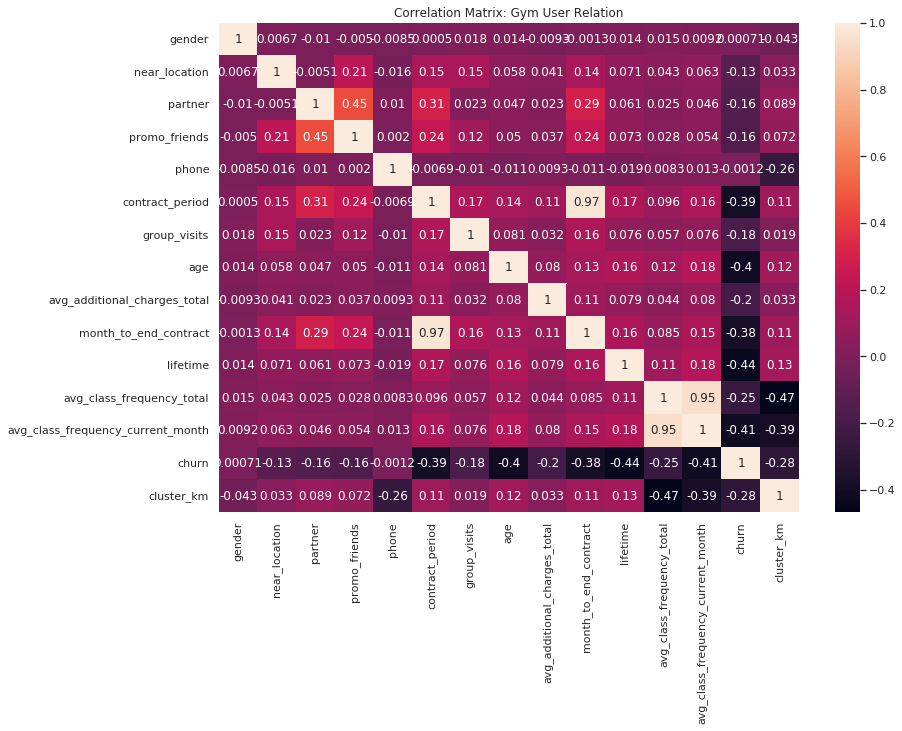

In [20]:
matrix = np.triu(data.corr())
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Correlation Matrix: Gym User Relation')
sns.heatmap(data.corr(), annot=True)
plt.show()

<h4>Conclusion

We can here notice that:
- avg_class_frequency_current_month and avg_class_frequency_total have a high corelation, probably because users are predetermined when to attend the gym.
- Month_to_end_contract and contract_period are also strongly corelated, for similar reasons as above.
- Notice that Lifetime and avg_class_frequency_current_month doesn't matter if a user wants to leave the gym.

# Step 3. Build a model to predict user churn

<h3>Divide the data into train and validation sets using the train_test_split() function.

In [11]:
# divide the data into features (the X matrix) and a target variable (y)
X = data.drop('churn', axis = 1)
y = data['churn']


# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# train StandardScaler on the train set
scaler = StandardScaler()
scaler.fit(X_train)

# transform train and test sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

<h4>Conclusion

Divided the data using train_test_split

<h3>Train the model on the train set with two methods:
    <ul>logistic regression</ul>
    <ul>random forest

In [12]:

# define the algorithm for the logistic regression model
lr_model = LogisticRegression(random_state=0)
# train the model
lr_model.fit(X_train_st, y_train)
# use the trained model to make predictions
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]



# define the algorithm for the new random forest model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # write your code here
# train the random forest model
rf_model.fit(X_train_st, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st)# write your code here
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]# write your code here



<h3>Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?

In [13]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

# print all metrics
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')
print()
# print all metrics
print_all_metrics(y_test,rf_predictions,rf_probabilities, title = 'Metrics for random forest:')


Metrics for logistic regression:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97

Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


<h4>Conclusion

Even though they are very similar, Metrics for logistic regression has a better Precision and Recall. Well, we got a classification rate of 92% in both the cases, which can be considered as good accuracy.

# Step 4. Create user clusters

<h3>Standardize the data.
<h3>Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram.

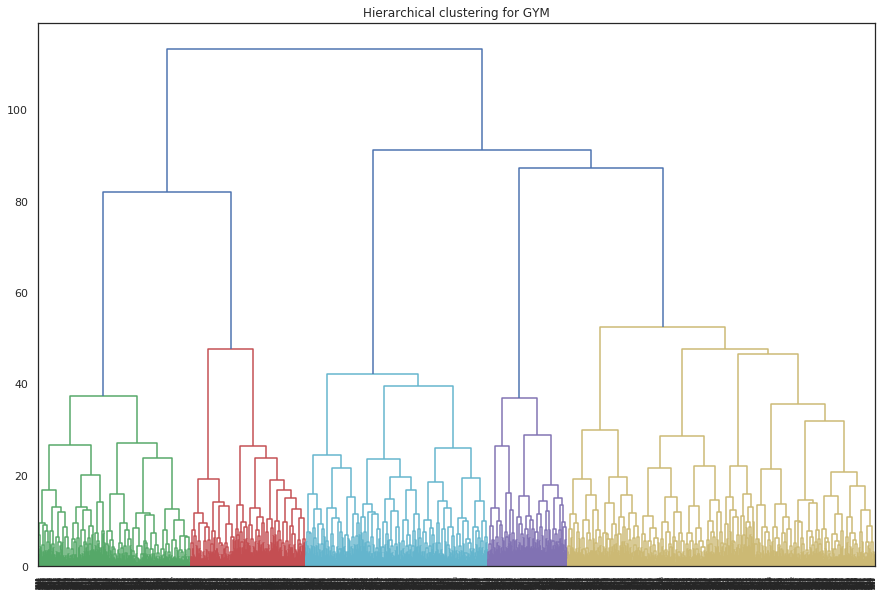

In [14]:

# the  standardization of data before passing it to the algorithm
sc = StandardScaler()
X_sc = sc.fit_transform(data)

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show()



<h4>Conclusion

Dendograms help in the distance between the objects and the agglomerative hierarchical clustering itself. It helps to estimate the proximity between the users. Here it gave us the optimal number of clusters - 5, thus helping in  launching the faster K-means algorithm.

<h3>Train the clustering model with the K-means algorithm and predict customer clusters.

In [21]:
# the  standardization of data before passing it to the algorithm
sc = StandardScaler()
X_sc = sc.fit_transform(data)

km = KMeans(n_clusters = 5,random_state=0) # setting the number of clusters as 5
labels = km.fit_predict(X_sc) # applying the algorithm to the data and forming a cluster vector



Set the number of clusters to 5 as suggested.

<h3>Look at the mean feature values for clusters. 

In [22]:
# store cluster labels in the field of our dataset
data['cluster_km'] = labels

# get the statistics of the mean feature values per cluster
data_group_mean = data.groupby(['cluster_km']).mean().reset_index()
data_group_mean

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502580,0.939112,0.767802,0.564499,1.000000,11.164087,0.559340,29.906089,161.453394,10.213622,4.704850,2.010782,2.005457,0.015480
1,1,0.524804,0.866841,0.469974,0.308094,0.000000,4.806789,0.428198,29.331593,144.156967,4.493473,3.945170,1.855107,1.723740,0.263708
2,2,0.507447,0.760638,0.341489,0.179787,0.997872,1.567021,0.257447,26.908511,115.109065,1.513830,0.976596,1.448700,1.026250,0.997872
3,3,0.551358,0.839433,0.374262,0.213695,0.998819,2.729634,0.439197,29.979929,160.154865,2.511216,4.589138,2.927620,2.934269,0.007084
4,4,0.475029,0.828107,0.447154,0.254355,1.000000,2.649245,0.382114,30.008130,153.612964,2.465738,4.673635,1.179620,1.178544,0.001161


<h4>Conclusion

- Users from cluster 0 have not provided their phone numbers whereas all others have
- cluster 1 users have location a near location and cluster 5 users have a far away location
- cluster 2 users with mean age of 30 have the highest Avg_class_frequency_total, Avg_additional_charges_total and Lifetime closely followed by cluster 3 users

<h3>Plot distributions of features for the clusters. 

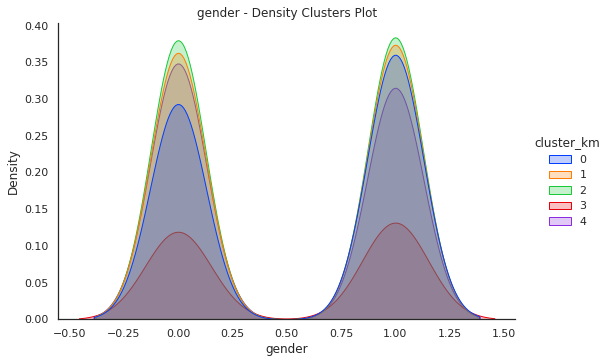

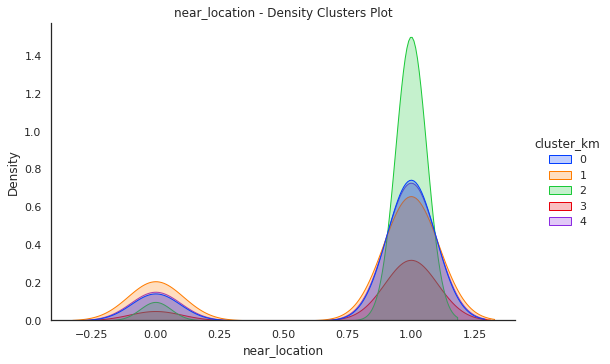

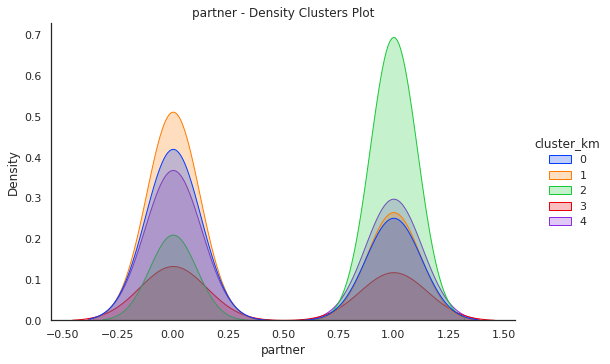

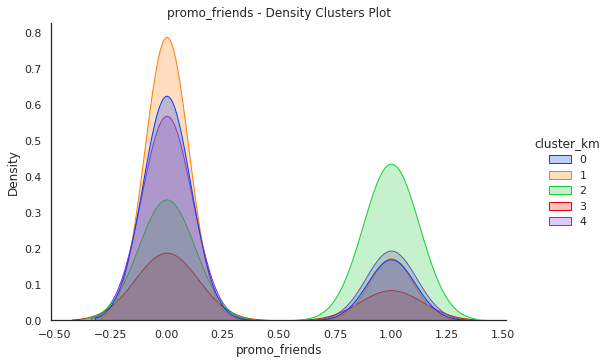

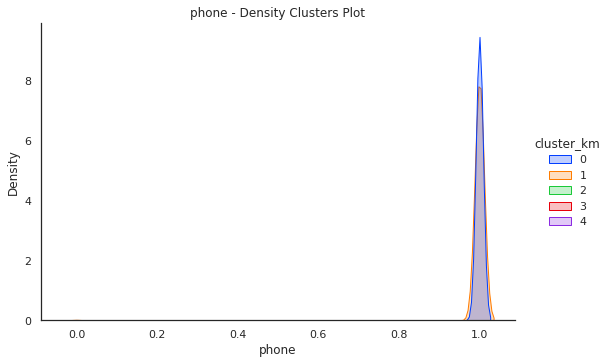

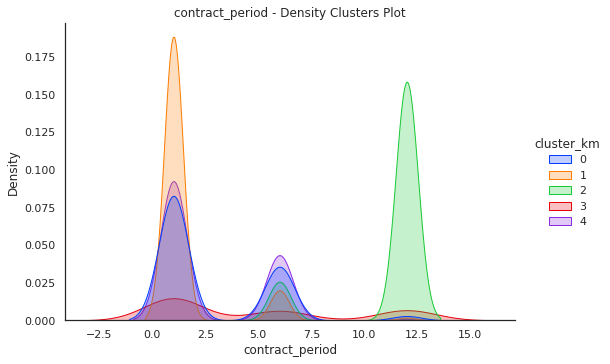

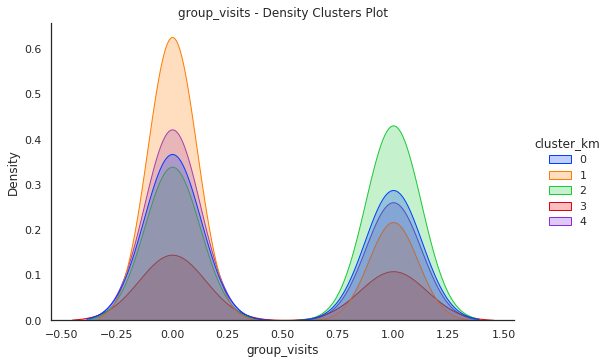

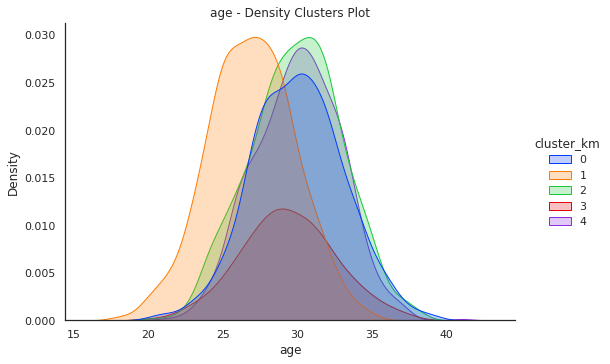

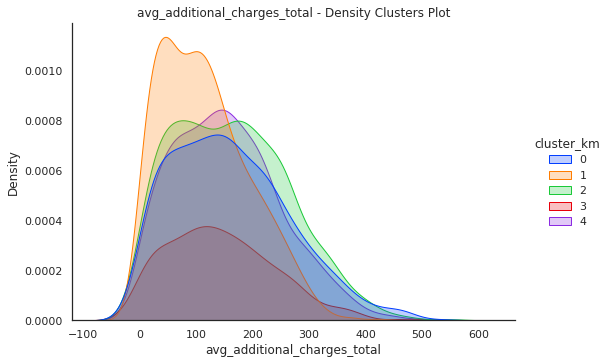

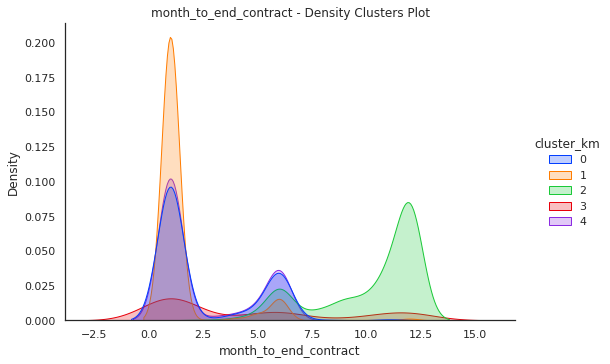

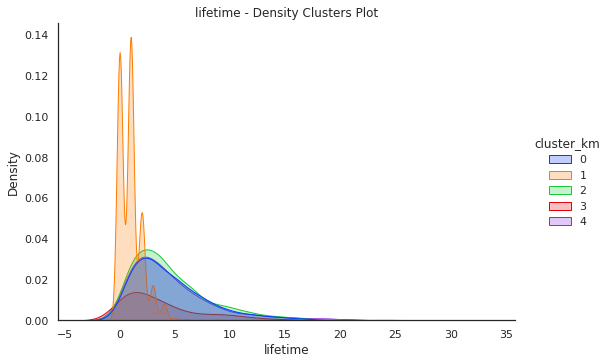

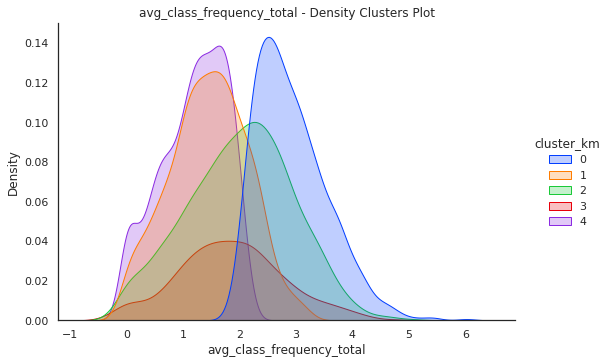

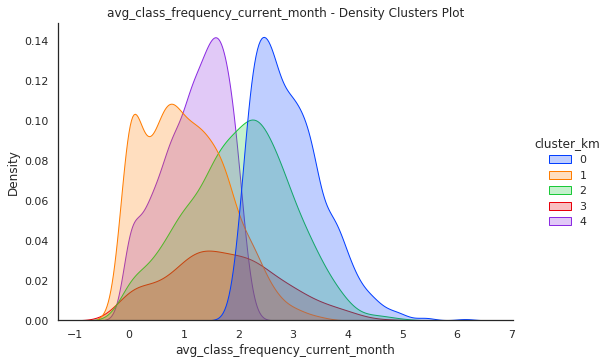

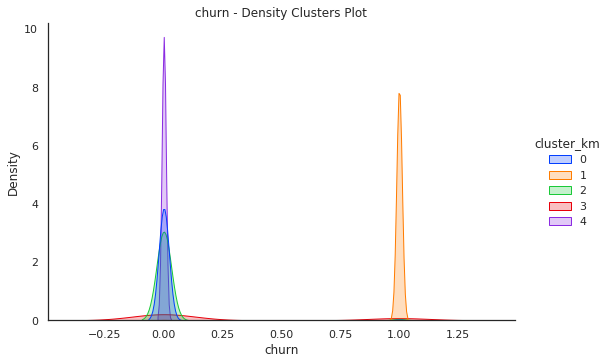

In [17]:

for feature in data.columns:
    if feature != 'cluster_km':
        sns.displot(
            data=data, x=feature, hue='cluster_km', kind='kde', fill=True, palette=sns.color_palette('bright')[:5], height=5, aspect=1.5
        )
        plt.title('{} - Density Clusters Plot'.format(feature))
        plt.show()

<h4>Conclusion

- The gender ratio is divided similarily among all clusters.
- cluster 2 users have the nearest location to the gym
- cluster 3 are the ones who are tied up with a Partner company and cluster 1 are self registered and there is only a slight difference in them. Same goes for the registration through promo code but here there is a considerable difference between them.
- cluster 3 users have the highest contract period and lowest being cluster 1 users, same goes for months to end contract
- cluster 3 users participate more in group visits and  cluster 1 users work out by themselves
- average ages of all cluster users plays around 28-30
- the average additional charge is aroung 150, cluster 1 users are more in number
- cluster 2 users have Avg_class_frequency_total and Avg_class_frequency_current_month, followed by cluster 3 and cluster 2 users
- thus cluster 1 users churn a lot more than cluster 3 users

<h3>Calculate the churn rate for each cluster 

In [18]:
churn_rate = data.groupby('cluster_km')['churn'].value_counts().to_frame().rename(columns={'churn': 'count'})
churn_rate

count
cluster_km churn       
0          0        841
           1          6
1          1        938
           0          2
2          0        954
           1         15
3          0        282
           1        101
4          0        860
           1          1

<h4>Conclusion

- Cluster 3 users are the most loyal amongst all - they have a churn rate of only 2.5%, followed by cluster 2.
- Cluster 1 and cluster 4 are more prone to leaving.
- Cluster 0 has 50-50 situation going on with them.

# Step 5. Come up with conclusions and basic recommendations on working with customers

From the above conclusions we see that - 
 - Location plays a major part in reducing the churn rate, we could focus on advertising locally to the gym - say in restaurants and theater as well as brochures and pamphlets can be mailed to nearby residential arears.
 - Partner tie ups and promotion codes yield good results, probably because there is already a trust factor based on which users stay. Therefore we can give rewards to companies and friends who have recommended so that the chain continues thus bring in more customers.
 - As seen larger contract period results in longer stay, we can offer discounted prices when a user registers for a longer time.
 - Group Activities were also favoured - We could increase group activities, increase the number of people participation as well as types of group activities say Yoga, Dance sessions, etc.
 - Most number of people who workout are in the age group of 28-30, so we could target them and advertise more to this age cohort and provide them with discounts and offers.

Thank You!